# Global Cyberattack Pattern Analysis — Data Mining (Anaconda Edition)

**Notebook:** 07_model_tuning.ipynb — GridSearchCV (RandomForest)

Dataset shape: (1442, 17)
            cveID vendorProject                         product  \
0  CVE-2025-54253         Adobe  Experience Manager (AEM) Forms   
1  CVE-2025-47827          IGEL                         IGEL OS   
2  CVE-2025-24990     Microsoft                         Windows   
3  CVE-2025-59230     Microsoft                         Windows   
4   CVE-2025-6264        Rapid7                    Velociraptor   

                                   vulnerabilityName   dateAdded  \
0  Adobe Experience Manager Forms Code Execution ...  2025-10-15   
1  IGEL OS Use of a Key Past its Expiration Date ...  2025-10-14   
2  Microsoft Windows Untrusted Pointer Dereferenc...  2025-10-14   
3  Microsoft Windows Improper Access Control Vuln...  2025-10-14   
4  Rapid7 Velociraptor Incorrect Default Permissi...  2025-10-14   

                                    shortDescription  \
0  Adobe Experience Manager Forms in JEE contains...   
1  IGEL OS contains a use of a key past its expir.

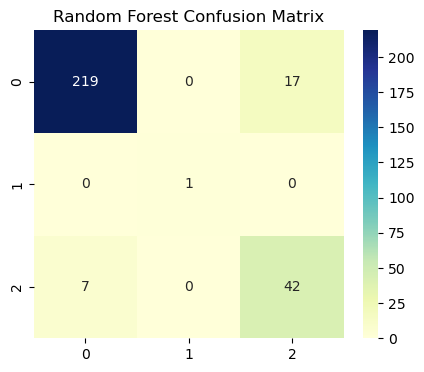


Best Logistic Regression Params: {'C': 10, 'solver': 'lbfgs'}

Logistic Regression Results:
Accuracy: 0.8706293706293706
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       236
           1       0.00      0.00      0.00         1
           2       0.60      0.80      0.68        49

    accuracy                           0.87       286
   macro avg       0.52      0.56      0.53       286
weighted avg       0.89      0.87      0.88       286


Model Comparison:


,Model,Accuracy
0,RandomForest,0.916084
1,LogisticRegression,0.870629


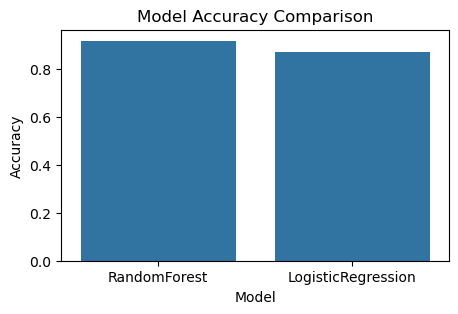

In [8]:
import warnings
warnings.filterwarnings("ignore")

# Supervised Learning - Model Training & Tuning
# Predict exploit speed or ransomware presence

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed dataset

df = pd.read_csv("data/cisa_preprocessed.csv")
print("Dataset shape:", df.shape)
print(df.head())

# TARGET & FEATURES
# Example target: exploit_speed (Fast / Medium / Slow)

target = "response_speed"

# Drop rows without target

df = df.dropna(subset=[target])

# Select feature columns

features = ['year_added', 'month_added', 'vendorProject', 'product', 'cwe_primary', 'ransomware_known']
df = df[features + [target]]

# Encode categorical columns

enc = LabelEncoder()
for col in ['vendorProject', 'product', 'cwe_primary']:
    df[col] = enc.fit_transform(df[col].astype(str))

# Encode target variable

df[target] = enc.fit_transform(df[target].astype(str))

# Split data safely even if some classes are rare

X = df[features]
y = df[target]

# If any class has fewer than 3 samples, skip stratify to avoid warning

if y.value_counts().min() < 3:
    stratify_param = None
else:
    stratify_param = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=stratify_param, random_state=42
)

# Normalize numerical features

scaler = StandardScaler()
X_train[['year_added', 'month_added']] = scaler.fit_transform(X_train[['year_added', 'month_added']])
X_test[['year_added', 'month_added']] = scaler.transform(X_test[['year_added', 'month_added']])

#  RANDOM FOREST

rf = RandomForestClassifier(random_state=42)
params_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(rf, params_rf, cv=3, n_jobs=-1, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print("Best RF Params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# Evaluate

y_pred = best_rf.predict(X_test)
print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Random Forest Confusion Matrix")
plt.show()

# LOGISTIC REGRESSION

logreg = LogisticRegression(max_iter=2000)
params_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
grid_lr = GridSearchCV(logreg, params_lr, cv=3, n_jobs=-1, scoring='accuracy')
grid_lr.fit(X_train, y_train)

print("\nBest Logistic Regression Params:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

# Evaluate

y_pred_lr = best_lr.predict(X_test)
print("\nLogistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Compare models

results = pd.DataFrame({
    "Model": ["RandomForest", "LogisticRegression"],
    "Accuracy": [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_lr)]
})
print("\nModel Comparison:")
display(results)

plt.figure(figsize=(5,3))
sns.barplot(x="Model", y="Accuracy", data=results)
plt.title("Model Accuracy Comparison")
plt.show()

